In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

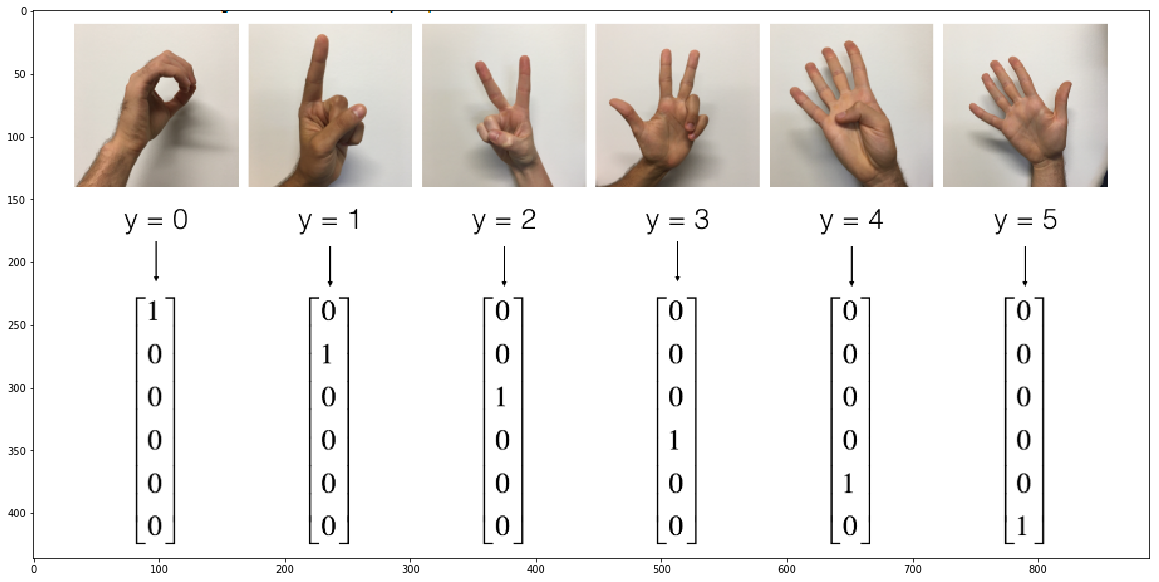

In [3]:
img=Image.open("images/signs.png")
plt.figure(figsize=(20,20))
plt.imshow(img)

y = 5
y = 5


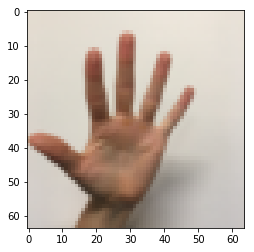

In [4]:
index = 3
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
print ("y = " + str((Y_train_orig[0, index])))

<h1>data shape</h1>

In [5]:

X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}


number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [6]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    为session创建占位符

    参数：
        n_H0 - 实数，输入图像的高度
        n_W0 - 实数，输入图像的宽度
        n_C0 - 实数，输入的通道数
        n_y  - 实数，分类数

    输出：
        X - 输入数据的占位符，维度为[None, n_H0, n_W0, n_C0]，类型为"float"
        Y - 输入数据的标签的占位符，维度为[None, n_y]，维度为"float"
    """
    X = tf.placeholder(tf.float32,[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32,[None, n_y])

    return X,Y

In [7]:
X , Y = create_placeholders(64,64,3,6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [8]:
def initialize_parameters():
    """
    初始化权值矩阵，这里我们把权值矩阵硬编码：
    W1 : [4, 4, 3, 8]
    W2 : [2, 2, 8, 16]

    返回：
        包含了tensor类型的W1、W2的字典
    """
    tf.set_random_seed(1)

    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}

    return parameters

In [9]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

    sess_test.close()



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


<h1>CONV2D→RELU→MAXPOOL→CONV2D→RELU→MAXPOOL→FULLCONNECTED</h1>

In [10]:
def forward_propagation(X,parameters):
    """
    实现前向传播
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    参数：
        X - 输入数据的placeholder，维度为(输入节点数量，样本数量)
        parameters - 包含了“W1”和“W2”的python字典。

    返回：
        Z3 - 最后一个LINEAR节点的输出

    """
    W1 = parameters['W1']
    W2 = parameters['W2']

    #Conv2d : 步伐：1，填充方式：“SAME”
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    #ReLU ：
    A1 = tf.nn.relu(Z1)
    #Max pool : 窗口大小：8x8，步伐：8x8，填充方式：“SAME”
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding="SAME")

    #Conv2d : 步伐：1，填充方式：“SAME”
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    #ReLU ：
    A2 = tf.nn.relu(Z2)
    #Max pool : 过滤器大小：4x4，步伐：4x4，填充方式：“SAME”
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")

    #一维化上一层的输出
    P = tf.contrib.layers.flatten(P2)

    #全连接层（FC）：使用没有非线性激活函数的全连接层
    Z3 = tf.contrib.layers.fully_connected(P,6,activation_fn=None)

    return Z3


In [11]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Instructions for updating:
Use keras.layers.flatten instead.
Z3 = [[ 1.4416984  -0.24909666  5.450499   -0.2618962  -0.20669907  1.3654671 ]
 [ 1.4070846  -0.02573211  5.08928    -0.48669922 -0.40940708  1.2624859 ]]


In [12]:
def compute_cost(Z3,Y):
    """
    计算成本
    参数：
        Z3 - 正向传播最后一个LINEAR节点的输出，维度为（6，样本数）。
        Y - 标签向量的placeholder，和Z3的维度相同

    返回：
        cost - 计算后的成本

    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))

    return cost


In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = 4.6648693


In [14]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.005,
          num_epochs=100, minibatch_size=64, print_cost=True):
    
    
    """
    使用TensorFlow实现三层的卷积神经网络
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    参数：
        X_train - 训练数据，维度为(None, 64, 64, 3)
        Y_train - 训练数据对应的标签，维度为(None, n_y = 6)
        X_test - 测试数据，维度为(None, 64, 64, 3)
        Y_test - 训练数据对应的标签，维度为(None, n_y = 6)
        learning_rate - 学习率
        num_epochs - 遍历整个数据集的次数
        minibatch_size - 每个小批量数据块的大小
        print_cost - 是否打印成本值，每遍历100次整个数据集打印一次

    返回：
        train_accuracy - 实数，训练集的准确度
        test_accuracy - 实数，测试集的准确度
        parameters - 学习后的参数
    """

    ops.reset_default_graph()                     #能够重新运行模型而不覆盖tf变量
    tf.set_random_seed(1)                           
    seed = 3                                         #指定numpy的随机种子
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    

    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()

    Z3 = forward_propagation(X, parameters)

    cost = compute_cost(Z3, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    #全局初始化所有变量
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
         #初始化参数
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

              
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # 打印
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        #绘图
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

       ## 计算当前的预测情况
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
         ##计算准确度
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters


Cost after epoch 0: 1.927888
Cost after epoch 5: 1.854550
Cost after epoch 10: 1.437623
Cost after epoch 15: 1.174663
Cost after epoch 20: 0.865305
Cost after epoch 25: 0.678087
Cost after epoch 30: 0.544750
Cost after epoch 35: 0.491814
Cost after epoch 40: 0.400171
Cost after epoch 45: 0.352771
Cost after epoch 50: 0.328606
Cost after epoch 55: 0.295914
Cost after epoch 60: 0.249357
Cost after epoch 65: 0.255357
Cost after epoch 70: 0.239984
Cost after epoch 75: 0.196407
Cost after epoch 80: 0.208048
Cost after epoch 85: 0.209179
Cost after epoch 90: 0.150095
Cost after epoch 95: 0.146479


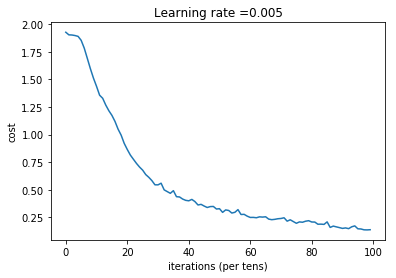

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.93796295
Test Accuracy: 0.84166664


In [15]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

D:\soft\conda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
D:\soft\conda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


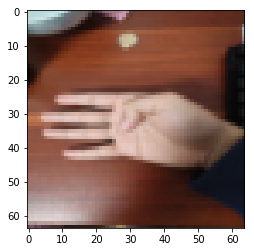

In [17]:
fname = "images/finger_4.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)